# NB05: TnSeq Coverage Gap Analysis

**Project**: ADP1 Deletion Collection Phenotype Analysis

**Goal**: Among TnSeq-classified genes that lack deletion mutant growth data, characterize which genes are missing and why. Focus on the 370 dispensable genes unexpectedly absent from the deletion collection.

**Input**: `data/all_genes_annotated.csv`

**Outputs**:
- `data/tnseq_gap_analysis.csv` — all TnSeq genes with gap classification
- Functional comparison of missing vs present dispensable genes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'

df = pd.read_csv(os.path.join(DATA_DIR, 'all_genes_annotated.csv'))

GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]

df['has_growth'] = df[GROWTH_COLS].notna().any(axis=1)
df['has_tnseq'] = df['essentiality_minimal'].notna()

print(f'Total genes: {len(df):,}')
print(f'With TnSeq: {df["has_tnseq"].sum():,}')
print(f'With growth: {df["has_growth"].sum():,}')

Total genes: 5,852
With TnSeq: 3,405
With growth: 2,350


## 1. TnSeq × Growth Data Coverage

In [2]:
# Cross-tabulation
tnseq_genes = df[df['has_tnseq']].copy()

print('=== TnSeq Genes by Class × Growth Data ===')
ct = pd.crosstab(tnseq_genes['essentiality_minimal'],
                 tnseq_genes['has_growth'].map({True: 'Has growth', False: 'No growth'}),
                 margins=True)
print(ct)

# Genes with TnSeq but NO growth data
gap_genes = tnseq_genes[~tnseq_genes['has_growth']].copy()
print(f'\nTnSeq genes WITHOUT growth data: {len(gap_genes):,}')
print(f'  Essential:    {(gap_genes["essentiality_minimal"] == "essential").sum():>5}')
print(f'  Dispensable:  {(gap_genes["essentiality_minimal"] == "dispensable").sum():>5}')
print(f'  Uncertain:    {(gap_genes["essentiality_minimal"] == "uncertain").sum():>5}')

=== TnSeq Genes by Class × Growth Data ===
has_growth            Has growth  No growth   All
essentiality_minimal                             
dispensable                 2321        272  2593
essential                      0        499   499
uncertain                      3        310   313
All                         2324       1081  3405

TnSeq genes WITHOUT growth data: 1,081
  Essential:      499
  Dispensable:    272
  Uncertain:      310


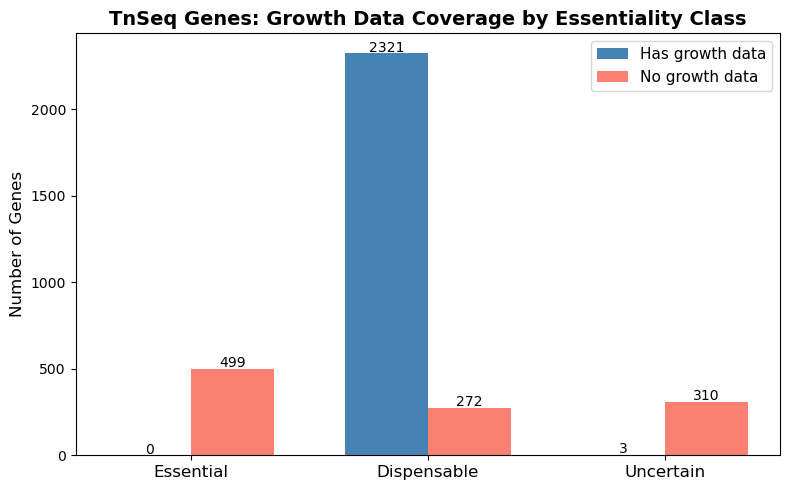

Saved: figures/tnseq_gap_coverage.png


In [3]:
# Visualize the gap
fig, ax = plt.subplots(figsize=(8, 5))

classes = ['essential', 'dispensable', 'uncertain']
has_growth_counts = []
no_growth_counts = []

for cls in classes:
    mask = tnseq_genes['essentiality_minimal'] == cls
    has_growth_counts.append((mask & tnseq_genes['has_growth']).sum())
    no_growth_counts.append((mask & ~tnseq_genes['has_growth']).sum())

x = np.arange(len(classes))
width = 0.35
ax.bar(x - width/2, has_growth_counts, width, label='Has growth data', color='steelblue')
ax.bar(x + width/2, no_growth_counts, width, label='No growth data', color='salmon')

for i, (h, n) in enumerate(zip(has_growth_counts, no_growth_counts)):
    ax.text(i - width/2, h + 10, str(h), ha='center', fontsize=10)
    ax.text(i + width/2, n + 10, str(n), ha='center', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in classes], fontsize=12)
ax.set_ylabel('Number of Genes', fontsize=12)
ax.set_title('TnSeq Genes: Growth Data Coverage by Essentiality Class',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'tnseq_gap_coverage.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/tnseq_gap_coverage.png')

## 2. Missing Dispensable Genes — Functional Comparison

370 dispensable genes lack growth data. They should have been in the deletion collection. What's different about them?

In [4]:
# Split dispensable genes into present (have growth data) vs missing (no growth data)
dispensable = tnseq_genes[tnseq_genes['essentiality_minimal'] == 'dispensable'].copy()
present = dispensable[dispensable['has_growth']].copy()
missing = dispensable[~dispensable['has_growth']].copy()

print(f'Dispensable genes total: {len(dispensable):,}')
print(f'  With growth data (present): {len(present):,}')
print(f'  Without growth data (missing): {len(missing):,}')

# Compare basic properties
print('\n=== Gene Length Comparison ===')
print(f'Present: mean={present["length"].mean():.0f} bp, median={present["length"].median():.0f} bp')
print(f'Missing: mean={missing["length"].mean():.0f} bp, median={missing["length"].median():.0f} bp')

# Annotation coverage
print('\n=== Annotation Coverage ===')
for col, name in [('rast_function', 'RAST'), ('ko', 'KO'), ('pfam', 'PFAM'), ('cog', 'COG')]:
    pct_present = present[col].notna().mean()
    pct_missing = missing[col].notna().mean()
    print(f'{name:6s}  present={pct_present:.1%}  missing={pct_missing:.1%}  '
          f'delta={pct_present-pct_missing:+.1%}')

Dispensable genes total: 2,593
  With growth data (present): 2,321
  Without growth data (missing): 272

=== Gene Length Comparison ===
Present: mean=981 bp, median=852 bp
Missing: mean=813 bp, median=636 bp

=== Annotation Coverage ===
RAST    present=100.0%  missing=90.8%  delta=+9.2%
KO      present=58.5%  missing=48.9%  delta=+9.6%
PFAM    present=100.0%  missing=90.8%  delta=+9.2%
COG     present=6.7%  missing=6.2%  delta=+0.5%


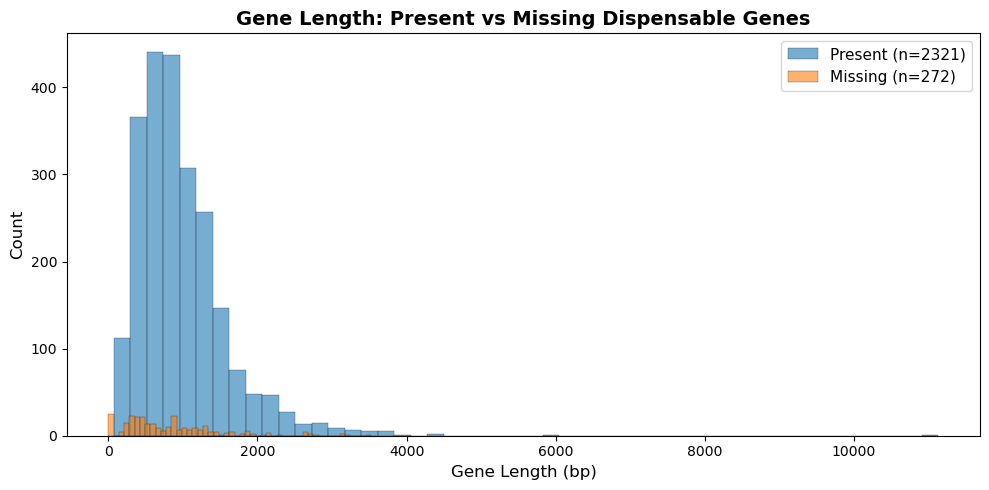

In [5]:
# Gene length distribution comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(present['length'], bins=50, alpha=0.6, label=f'Present (n={len(present)})',
        edgecolor='black', linewidth=0.3)
ax.hist(missing['length'], bins=50, alpha=0.6, label=f'Missing (n={len(missing)})',
        edgecolor='black', linewidth=0.3)
ax.set_xlabel('Gene Length (bp)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Gene Length: Present vs Missing Dispensable Genes', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'missing_gene_length.png'), dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# RAST function enrichment in missing vs present dispensable genes
# Which functions are overrepresented among the missing genes?
present['rast_clean'] = present['rast_function'].fillna('Hypothetical')
missing['rast_clean'] = missing['rast_function'].fillna('Hypothetical')

total_disp = len(dispensable)

# Count functions in each group
present_counts = present['rast_clean'].value_counts()
missing_counts = missing['rast_clean'].value_counts()

# Test functions present in >=3 missing genes
test_funcs = missing_counts[missing_counts >= 3].index.tolist()
print(f'Functions with >=3 missing genes: {len(test_funcs)}')

enrich_results = []
for func in test_funcs:
    a = missing_counts.get(func, 0)  # missing with function
    b = len(missing) - a  # missing without function
    c = present_counts.get(func, 0)  # present with function
    d = len(present) - c  # present without function
    
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='greater')
    enrich_results.append({
        'function': func,
        'missing_count': a,
        'present_count': c,
        'odds_ratio': odds_ratio,
        'p_value': p_value
    })

df_enrich = pd.DataFrame(enrich_results)
if len(df_enrich) > 0:
    reject, qvals, _, _ = multipletests(df_enrich['p_value'], method='fdr_bh', alpha=0.05)
    df_enrich['q_value'] = qvals
    df_enrich['significant'] = reject
    
    sig = df_enrich[df_enrich['significant']].sort_values('q_value')
    print(f'Significant enrichments (q<0.05): {len(sig)}')
    
    if len(sig) > 0:
        print('\n=== Functions Enriched in Missing Dispensable Genes ===')
        for _, row in sig.iterrows():
            print(f'  {row["function"][:55]:55s} '
                  f'missing={row["missing_count"]:>3} present={row["present_count"]:>3} '
                  f'OR={row["odds_ratio"]:>5.1f} q={row["q_value"]:.2e}')
    else:
        print('No functions significantly enriched among missing genes')
        print('\nTop 10 by p-value (not significant after FDR):')
        for _, row in df_enrich.nsmallest(10, 'p_value').iterrows():
            print(f'  {row["function"][:55]:55s} '
                  f'missing={row["missing_count"]:>3} present={row["present_count"]:>3} '
                  f'OR={row["odds_ratio"]:>5.1f} p={row["p_value"]:.2e}')

Functions with >=3 missing genes: 2
Significant enrichments (q<0.05): 2

=== Functions Enriched in Missing Dispensable Genes ===
  Hypothetical                                            missing= 25 present=  0 OR=  inf q=2.38e-25
  hypothetical protein                                    missing= 48 present=236 OR=  1.9 q=3.01e-04


## 3. Pangenome Context — Core vs Accessory

In [7]:
# Compare pangenome conservation between present and missing dispensable genes
# pangenome_is_core: True/False/NaN
present_core = present['pangenome_is_core'].fillna(False).astype(bool).mean()
missing_core = missing['pangenome_is_core'].fillna(False).astype(bool).mean()

print('=== Pangenome Core Status ===')
print(f'Present dispensable: {present_core:.1%} core')
print(f'Missing dispensable: {missing_core:.1%} core')

# Chi-squared test
present_core_n = present['pangenome_is_core'].fillna(False).astype(bool).sum()
missing_core_n = missing['pangenome_is_core'].fillna(False).astype(bool).sum()
table = [[present_core_n, len(present) - present_core_n],
         [missing_core_n, len(missing) - missing_core_n]]
chi2, p, dof, expected = chi2_contingency(table)
print(f'Chi-squared test: chi2={chi2:.1f}, p={p:.2e}')

=== Pangenome Core Status ===
Present dispensable: 93.3% core
Missing dispensable: 76.5% core
Chi-squared test: chi2=86.4, p=1.44e-20


## 4. Uncertain Genes — Properties

In [8]:
# Uncertain genes — do they look more like essential or dispensable?
essential = tnseq_genes[tnseq_genes['essentiality_minimal'] == 'essential']
uncertain = tnseq_genes[tnseq_genes['essentiality_minimal'] == 'uncertain']

print('=== Properties by TnSeq Class ===')
print(f'{"Property":30s} {"Essential":>12s} {"Uncertain":>12s} {"Dispensable":>12s}')
print('-' * 70)

# Gene length
print(f'{"Mean length (bp)":30s} {essential["length"].mean():>12.0f} '
      f'{uncertain["length"].mean():>12.0f} {dispensable["length"].mean():>12.0f}')

# Annotation rate
for col, name in [('rast_function', 'RAST annotation %'), ('ko', 'KO annotation %'),
                  ('pfam', 'PFAM annotation %')]:
    print(f'{name:30s} {essential[col].notna().mean():>12.1%} '
          f'{uncertain[col].notna().mean():>12.1%} {dispensable[col].notna().mean():>12.1%}')

# Core genome %
for cls_name, cls_df in [('Essential', essential), ('Uncertain', uncertain), ('Dispensable', dispensable)]:
    core_pct = cls_df['pangenome_is_core'].fillna(False).astype(bool).mean()

print(f'{"Core genome %":30s} '
      f'{essential["pangenome_is_core"].fillna(False).astype(bool).mean():>12.1%} '
      f'{uncertain["pangenome_is_core"].fillna(False).astype(bool).mean():>12.1%} '
      f'{dispensable["pangenome_is_core"].fillna(False).astype(bool).mean():>12.1%}')

# Growth data coverage
print(f'{"Has growth data %":30s} {essential["has_growth"].mean():>12.1%} '
      f'{uncertain["has_growth"].mean():>12.1%} {dispensable["has_growth"].mean():>12.1%}')

=== Properties by TnSeq Class ===
Property                          Essential    Uncertain  Dispensable
----------------------------------------------------------------------
Mean length (bp)                       1028          361          963
RAST annotation %                     99.8%        41.5%        99.0%
KO annotation %                       86.2%        19.8%        57.5%
PFAM annotation %                     99.8%        41.5%        99.0%
Core genome %                         94.2%        31.3%        91.5%
Has growth data %                      0.0%         1.0%        89.5%


## 5. Save Results

In [9]:
# Classify each TnSeq gene
tnseq_genes = tnseq_genes.copy()
tnseq_genes['gap_class'] = 'present_with_growth'
tnseq_genes.loc[~tnseq_genes['has_growth'] & (tnseq_genes['essentiality_minimal'] == 'essential'),
                'gap_class'] = 'essential_no_growth'
tnseq_genes.loc[~tnseq_genes['has_growth'] & (tnseq_genes['essentiality_minimal'] == 'dispensable'),
                'gap_class'] = 'missing_dispensable'
tnseq_genes.loc[~tnseq_genes['has_growth'] & (tnseq_genes['essentiality_minimal'] == 'uncertain'),
                'gap_class'] = 'uncertain_no_growth'

print('=== Gap Classification ===')
print(tnseq_genes['gap_class'].value_counts().to_string())

tnseq_genes.to_csv(os.path.join(DATA_DIR, 'tnseq_gap_analysis.csv'), index=False)
print(f'\nSaved: data/tnseq_gap_analysis.csv ({len(tnseq_genes):,} rows)')

print(f'\n=== NB05 Summary ===')
print(f'TnSeq genes analyzed: {len(tnseq_genes):,}')
print(f'Essential (expected gap): {(tnseq_genes["gap_class"]=="essential_no_growth").sum()}')
print(f'Missing dispensable (unexpected gap): {(tnseq_genes["gap_class"]=="missing_dispensable").sum()}')
print(f'Uncertain (ambiguous): {(tnseq_genes["gap_class"]=="uncertain_no_growth").sum()}')

=== Gap Classification ===
gap_class
present_with_growth    2324
essential_no_growth     499
uncertain_no_growth     310
missing_dispensable     272

Saved: data/tnseq_gap_analysis.csv (3,405 rows)

=== NB05 Summary ===
TnSeq genes analyzed: 3,405
Essential (expected gap): 499
Missing dispensable (unexpected gap): 272
Uncertain (ambiguous): 310
